In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as transforms
from torchvision.datasets import CIFAR10
import sys
import os


In [2]:
#adjustable hparams
batch_size = 64
lr = 1e-3
max_epochs = 25
latent_dim = 128
#change this to 'cuda'
device = 'cpu'

In [3]:
#dont touch
transform = transforms.ToTensor()
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)
np.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, suppress=True, nanstr=None, infstr=None, formatter=None, sign=None, floatmode=None, legacy=None)
dataset_path = '/Users/gpnuser/Documents/Horos Data/Jas_Pycharm/VAE'
train_data = CIFAR10(root=dataset_path, transform=transform, train=True, download=True)
validation_data = CIFAR10(root=dataset_path, train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
train_dict = enumerate(train_loader, 0)
loss_log = np.zeros(max_epochs,)
print(len(loss_log))

Files already downloaded and verified
Files already downloaded and verified
25


In [4]:
class Vae(torch.nn.Module):
        def __init__(self, img_dim=(65536), channels=3, latent_dim=latent_dim):
            super(
).__init__()

            #Encoder
            self.encoder_conv_1 = torch.nn.Conv2d(3,32,3,stride=1,padding=1)
            self.encoder_conv_2 = torch.nn.Conv2d(32,64,3,stride=1,padding=1)
            self.encoder_FC_1 = torch.nn.Linear(img_dim, latent_dim)
            self.encoder_FC_2 = torch.nn.Linear(img_dim, latent_dim)
            #Decoder
            self.decoder_FC_1 = torch.nn.Linear(128,65536)
            self.decoder_conv_1 = torch.nn.ConvTranspose2d(64,32,3,stride=1,padding=1)
            self.decoder_conv_2 = torch.nn.ConvTranspose2d(32,3,3,stride=1,padding=1)

        def encoder(self, x, img_dim=(32,32), channels=3, latent_dim=latent_dim):
            h = self.encoder_conv_1(x)
            h = self.encoder_conv_2(h)
            h = h.view(h.size(0), -1)
            mu = torch.Tensor(h)
            sigma = torch.Tensor(h)
            mu = self.encoder_FC_1(mu)
            sigma = self.encoder_FC_2(sigma)

            return mu, sigma

# meant to mirror the encoder architecture
        def decoder(self, k, img_dim=(32,32), channels=3, latent_dim=latent_dim):
            k = relu(k)
            k = torch.Tensor(self.decoder_FC_1(k))
            k = k.view(64, 64, 32, 32)
            k = relu(self.decoder_conv_1(k))
            k = torch.sigmoid(self.decoder_conv_2(k))
            return k


        def reparameterization(self, mu, sigma):
            eps = torch.randn_like(sigma)
            sigma = torch.exp(sigma/2)
            reparameterized = mu + sigma * eps
            return reparameterized


        def forward(self, x):
            mu, sigma = self.encoder(x)
            reparameterized = self.reparameterization(mu, sigma)
            z = self.decoder(reparameterized)
            return z, mu, sigma
#dont touch
relu = torch.nn.ReLU()
net = Vae().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
epoch = 0
def end():
    print('done')
    sys.exit()


In [5]:
#this code sucks and might be causing loss problems
def training_loop():
        for data in train_loader:
            global epoch
            global loss_log
            epoch += 1
            in_image, nothing = data
            in_image = in_image.to(device)
            out_image, mu, sigma = net(in_image)


            KL = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp(),dim=1)
            loss = torch.nn.functional.binary_cross_entropy(out_image, in_image) + KL
            loss = torch.mean(loss)
         #   loss_log[epoch-1] = loss
            print('Epoch is:', epoch)
            print('loss: is', loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoch == max_epochs:
                print('max epoch reached, learning has ended')
                in_image = in_image[0].to('cpu').permute(1,2,0).detach().numpy()
                out_image = out_image[1].to('cpu').permute(1,2,0).detach().numpy()
                plt.subplot(121)
                plt.imshow(in_image)
                plt.subplot(122)
                plt.imshow(out_image)
                end()


In [6]:
#vroom

#training_loop()

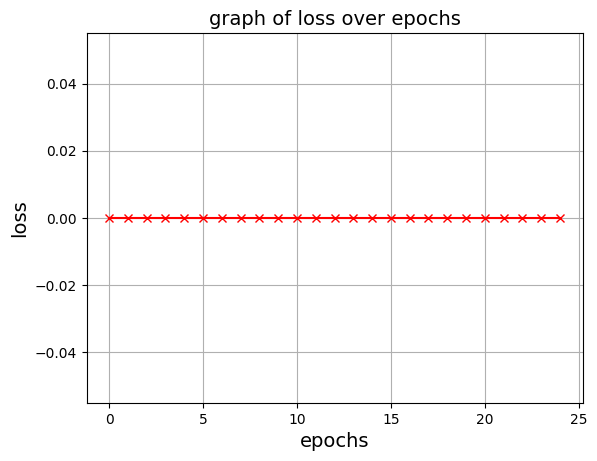

In [7]:
def plot_loss():
    epoch_axis = range(max_epochs)
    plt.plot(epoch_axis, loss_log, color='red', marker='x')
    plt.title('graph of loss over epochs', fontsize=14)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.grid(True)
    plt.show()
plot_loss()

In [8]:
# this is more or less the same thing as training loop, but with added functionality
# instead of completing the training, it stops on a target epoch, then summarizes I/O data for debugging purposes
epoch = 0
def tensor_debugger():
        for data in train_loader:
            global epoch
            global loss_log
            epoch += 1
            in_image, nothing = data
            in_image = in_image.to(device)
            out_image, mu, sigma = net(in_image)

            KL = -0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp(),dim=1)
            loss = torch.nn.functional.binary_cross_entropy(out_image, in_image) + KL
            loss = torch.mean(loss)
            print('Epoch is:', epoch)
            print('loss: is', loss)
            loss_log[epoch-1] = loss
            print('in-tensor summary: mean is', torch.mean(in_image))
            print('out-tensor summary: mean is', torch.mean(out_image))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if epoch == max_epochs:
                print('summarizing epoch', epoch, 'where loss is', loss)
                print('in-tensor summary: mean is', torch.mean(in_image))
                print('for the in tensor, sample of values is:', in_image[:,0,0])
                print('out-tensor summary: mean is', torch.mean(out_image))
                print('for the out tensor, sample of values is:', out_image[:,0,0])
                tensor_save(out_image)
                end()
tensor_debugger()

Epoch is: 1
loss: is tensor(1.6641, grad_fn=<MeanBackward0>)
in-tensor summary: mean is tensor(0.4543)
out-tensor summary: mean is tensor(0.5076, grad_fn=<MeanBackward0>)
Epoch is: 2
loss: is tensor(12848.2549, grad_fn=<MeanBackward0>)
in-tensor summary: mean is tensor(0.4761)
out-tensor summary: mean is tensor(0.4177, grad_fn=<MeanBackward0>)
Epoch is: 3
loss: is tensor(43.8545, grad_fn=<MeanBackward0>)
in-tensor summary: mean is tensor(0.4641)
out-tensor summary: mean is tensor(0.4861, grad_fn=<MeanBackward0>)
Epoch is: 4
loss: is tensor(362.7072, grad_fn=<MeanBackward0>)
in-tensor summary: mean is tensor(0.4763)
out-tensor summary: mean is tensor(0.4748, grad_fn=<MeanBackward0>)
Epoch is: 5
loss: is tensor(111.7514, grad_fn=<MeanBackward0>)
in-tensor summary: mean is tensor(0.4870)
out-tensor summary: mean is tensor(0.5024, grad_fn=<MeanBackward0>)
Epoch is: 6
loss: is tensor(754.1113, grad_fn=<MeanBackward0>)
in-tensor summary: mean is tensor(0.4696)
out-tensor summary: mean is ten

NameError: name 'tensor_save' is not defined

In [ ]:
#this is my function for saving tensors that I am interested in. For example, suppose I want to check the very first tensors generated by the system, Xin and Xout in Epoch 1. in that case, set Max epochs equal to one and run the tensor debugger function. The tensors are to be accessed by a function in a separate script that takes those tensors and provides summary statistics. The reason I might need summary statistics on the tensors manipulated by my program is if I want to see what exactly is it that might be screwing up my loss function. In this separate program, I would compare and contrast those tensors, and see if there is anything glaringly wrong with them, for example, if any of them are entirely zero. I am writing this because I have nobody to talk to in the lab.
def tensor_save(tensor):
    number_list = ['one', 'two', 'three', 'end']
    extension = number_list[epoch-1]
    if extension == 'end':
        print('end of list reached')
        raise ValueError
    file_name = 'out_image'+ extension + '.pt'
    if file_name.isfile():
        print('file already exists, no tensor will be saved')
    else:
        torch.save(tensor, file_name)
    print('saving the file as:', file_name)

